In [1]:
import json
import os
from time import time
# import re
import pandas as pd
import numpy as np
from collections import Counter
import functools
# from nltk import FreqDist
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
# from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics import accuracy_score 
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Activation, Dropout, Flatten, Reshape, Embedding, GlobalMaxPooling1D, Conv1D
from keras.optimizers import SGD 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Preprocessing

In [2]:
random_seed = 7

In [3]:
# takes path, returns list with of albums in json format
# each json entry is a song with lyrics and other metadata
def json_extract(path):
    data_list=[]
    for file in os.listdir(path): 
        if file[-5:] == '.json':
            with open(path+file, 'r') as f: 
                data = json.load(f)
                data_list.append(data)
    return data_list

In [4]:
path = 'data/drake/'
drake=json_extract(path)
path='data/quentin_miller/'
quentin=json_extract(path)

In [5]:
# remove obvious identifiers and stem words
stops={'drizzy', 'drake', 'quentin', 'miller', 'ovo', 'champagne', 'papi','toronto', 'atlanta', '6'}
analyze = CV().build_analyzer()
ps = PorterStemmer()

def stop_removal(lyrics : str): 
    toks=analyze(lyrics)
    return ' '.join([ps.stem(word) for word in toks if not ps.stem(word) in stops])

In [51]:
# resplit the data into train and test 
np.random.seed(random_seed)
X_train = []
train_titles=[]
iyrtitl_lyrics= []
iyrtitl_titles= []
X_test=[]
test_titles=[]
#count number of drake songs in train, test set
d_train_cnt=0
d_test_cnt=0
for album in drake: 
    for song in album: 
        # keep track of "If you're..." to put in test set (iytitl is subject to ambiguous authorship)
        if song["album"]=="If You’re Reading This It’s Too Late ":
            iyrtitl_titles.append(song['title'])
            iyrtitl_lyrics.append(stop_removal(song['lyrics']))
        # oversample from Drake to balance training sample further. 
        elif np.random.random(1) < .15:
            test_titles.append(song['title'])
            X_test.append(stop_removal(song['lyrics']))   
            d_test_cnt+=1
        else: 
            train_titles.append(song['title'])
            X_train.append(stop_removal(song['lyrics']))
            d_train_cnt+=1

for album in quentin: 
    for song in album: 
        if np.random.random(1) < .1:
            test_titles.append(song['title'])
            X_test.append(stop_removal(song['lyrics']))   
        else: 
            train_titles.append(song['title'])
            X_train.append(stop_removal(song['lyrics']))

# label drake as 0 and Quentin Miller as 1 in y column. 
y_train=np.zeros(len(X_train))    
y_train[d_train_cnt:]=1
y_test=np.zeros(len(X_test))
y_test[d_test_cnt:]=1

In [7]:
# keep track of validation accuracy of all models (NOT held out test set)
score_dict = {}
#track the cross-validated best estimator. 
model_dict = {}

In [8]:
# baseline preprocessing values to cv on. 
# commented out parameters performed better across the board or didn't provide much improvement so they have been moved to preprocessing or the default transformer
pipe_base = [ ('vect', CV(max_df=.5, ngram_range= (1, 2))), ('tfidf', TfidfTransformer())]
param_base = {   
#     'vect__max_df': (.4, .5), 
    'vect__min_df': (0.002, 0.005, 0.007), 
#     'vect__ngram_range' : (1, 2), (1,3)),
#     'vect__analyzer' : ('word', stemming),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'), 
}

In [9]:
# takes a pipeline, hyperparameters, and a number of folds. 
# prints information about the grid search and returns the GridSearchCV object with the best model
def grid_search(pipeline, param, k=6):
    model = RandomizedSearchCV(pipeline, param, random_state=random_seed, 
                              cv=k, n_iter=15, verbose =0)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:", param)
    start = time()
    model.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - start))
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:")
    for param_name in sorted(param.keys()):
        print("\t%s: %r" % (param_name, model.best_params_[param_name]))
    return model

In [10]:
# adds results from gridsearch to global variables model_dict and score_dict 
# key should be a three letter abbreviation for the model's name. 
def track_model (key, pipeline, param, k=5):
    global model_dict
    global score_dict
    grid = grid_search(pipeline, param, k)
    model_dict[key] = grid.best_estimator_
    score_dict[key] = grid.best_score_

## Logistic Regression

In [11]:
pipeline = Pipeline(steps=
                    pipe_base + [('clf', LogisticRegression(class_weight='balanced', 
                               random_state=random_seed, 
                               penalty='elasticnet', 
                               solver='saga'))])
params= param_base.copy()
params['clf__l1_ratio'] = (0, 0.1, 0.5, 0.9)
params['clf__C'] = (0.1, 1., 10, 100, 1000)

In [12]:
track_model('log', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__l1_ratio': (0, 0.1, 0.5, 0.9), 'clf__C': (0.1, 1.0, 10, 100, 1000)}


C:\Users\Tyler\Anaconda3\envs\research\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Tyler\Anaconda3\envs\research\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Tyler\Anaconda3\envs\research\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Tyler\Anaconda3\envs\research\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Tyler\Anaconda3\envs\research\lib\site-packages\sklearn\linear_model\_sag.py:330: C

done in 26.373s
Best score: 0.871
Best parameters set:
	clf__C: 1000
	clf__l1_ratio: 0.1
	tfidf__norm: 'l1'
	tfidf__use_idf: True
	vect__min_df: 0.005


C:\Users\Tyler\Anaconda3\envs\research\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Stochastic Gradient Decent

In [13]:
# use modified_huber to ensure we get probability estimates
pipeline = Pipeline(steps=pipe_base + [('clf', SGDClassifier(class_weight='balanced', 
                          random_state=random_seed,  loss= 'modified_huber'))])
params= param_base.copy()
params['clf__alpha'] = (0.0001, 0.001, 0.01)
params['clf__l1_ratio'] =(0, 0.5, 0.75, 1)
params['clf__tol'] = (0.0001, 0.001)
# params['clf__loss'] =  (‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’)

In [14]:
track_model('sgd', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__alpha': (0.0001, 0.001, 0.01), 'clf__l1_ratio': (0, 0.5, 0.75, 1), 'clf__tol': (0.0001, 0.001)}
done in 17.108s
Best score: 0.858
Best parameters set:
	clf__alpha: 0.001
	clf__l1_ratio: 1
	clf__tol: 0.0001
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__min_df: 0.002


## Support Vector Classification

In [15]:
# Use linear kernel to ensure probability estimates (however we can uncomment and delete to CV different kernels)
pipeline = Pipeline(steps=
    pipe_base + [('clf', SVC(kernel='linear', random_state=random_seed, 
                             class_weight='balanced', probability=True))])

params = param_base.copy()
# params['clf__kernel'] = ('linear', 'poly', 'rbf')
params['clf__C'] = (0.1, 0.5, 0.75, 0.9)



In [16]:
track_model('svc', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__C': (0.1, 0.5, 0.75, 0.9)}
done in 57.314s
Best score: 0.871
Best parameters set:
	clf__C: 0.9
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__min_df: 0.007


## Random forest 

In [17]:
pipeline = Pipeline(steps=
    pipe_base + [('clf', RandomForestClassifier(class_weight='balanced'))])

params= param_base.copy()
params['clf__n_estimators'] = (100, 150, 175) 
# params['clf__max_depth'] = (30, 50, 100)
params['clf__max_features'] = ('log2', 'auto')
# params['clf__min_samples_split'] = (2, 4, 8)

# params['clf__max_leaf_nodes'] = (5, 25, 50)

In [18]:
track_model('rfc', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__n_estimators': (100, 150, 175), 'clf__max_features': ('log2', 'auto')}
done in 33.678s
Best score: 0.828
Best parameters set:
	clf__max_features: 'auto'
	clf__n_estimators: 100
	tfidf__norm: 'l1'
	tfidf__use_idf: False
	vect__min_df: 0.007


## AdaBoost

In [19]:
pipeline = Pipeline(steps=
    pipe_base+[('clf', AdaBoostClassifier(random_state=random_seed))])

params = param_base.copy()
params['clf__base_estimator'] = (DTC(max_depth=1), DTC(max_depth=2), DTC(max_depth=4))
params['clf__n_estimators'] = (100, 120, 140)
params['clf__learning_rate'] = (0.2, 0.25, 0.3)

In [20]:
track_model('ada', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__base_estimator': (DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=4)), 'clf__n_estimators': (100, 120, 140), 'clf__learning_rate': (0.2, 0.25, 0.3)}
done in 146.510s
Best score: 0.825
Best parameters set:
	clf__base_estimator: DecisionTreeClassifier(max_depth=1)
	clf__learning_rate: 0.25
	clf__n_estimators: 120
	tfidf__norm: 'l2'
	tfidf__use_idf: False
	vect__min_df: 0.002


## Gradient Boosting

In [21]:
pipeline = Pipeline(steps=
                    pipe_base + [('clf', GradientBoostingClassifier(random_state=random_seed))])

params = param_base.copy()
params['clf__learning_rate'] =(0.15, 0.2, 0.25)
params['clf__n_estimators'] = (50, 75, 100)
params['clf__min_samples_leaf']= (1,2,5)
params['clf__max_depth'] = (2,3,5)
params['clf__min_impurity_decrease'] =  (0, 0.01, 0.05)
params['clf__tol'] =  (0.0001, 0.001, 0.005)

In [22]:
track_model('gbc', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__learning_rate': (0.15, 0.2, 0.25), 'clf__n_estimators': (50, 75, 100), 'clf__min_samples_leaf': (1, 2, 5), 'clf__max_depth': (2, 3, 5), 'clf__min_impurity_decrease': (0, 0.01, 0.05), 'clf__tol': (0.0001, 0.001, 0.005)}
done in 93.989s
Best score: 0.837
Best parameters set:
	clf__learning_rate: 0.2
	clf__max_depth: 2
	clf__min_impurity_decrease: 0
	clf__min_samples_leaf: 5
	clf__n_estimators: 100
	clf__tol: 0.005
	tfidf__norm: 'l2'
	tfidf__use_idf: False
	vect__min_df: 0.007


## Nueral Network

In [23]:
# fit on training data
maxlen = 700
num_words=3000
tokenizer=Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index)+1

In [24]:
# transform corpus into word embeddings
Xcnn_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=maxlen)
Xcnn_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=maxlen)
Xcnn_iyrtest = pad_sequences(tokenizer.texts_to_sequences(iyrtitl_lyrics), maxlen=maxlen)


In [25]:
earlyStopping = EarlyStopping(monitor='loss', min_delta=0.0005, 
                                              patience=10, verbose=0, mode='auto')

In [26]:
def random_grid_search(build_fn, params, k, epochs, batch_size, n_iter): 
    model = KerasClassifier(build_fn=build_fn, verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=params, cv=k, verbose=1, n_iter=n_iter)
    print("Performing grid search...")
    print("parameters:", params)
    start = time()
    result = grid.fit(Xcnn_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[earlyStopping])
    print("done in %0.3fs" % (time() - start))
    print("Best score: %0.3f" % result.best_score_)
    print("Best parameters set:")
    for param_name in sorted(params.keys()):
        print("\t%s: %r" % (param_name, result.best_params_[param_name]))
    return result
    
    
#     test_accuracy= grid.score(X_test, y_test)
#     print("validation accuracy of best model: {}\n".format(test_accuracy))
#     return result

In [27]:
# node layers currently only uses the first 2 elements as number of nodes in dense layers.
def build_fn(node_layer, num_filters, kernel_size, vocab_size, embedding_dim, maxlen): 
    model = Sequential([
        Embedding(input_dim = vocab_size, 
              output_dim = embedding_dim,
              input_length=maxlen),
        Conv1D(num_filters, kernel_size, activation='relu'),
        GlobalMaxPooling1D(), 
        Dense(node_layer, activation='relu'),
        Dense(node_layer, activation='relu'),
        Dense(1, activation='sigmoid')])
    model.compile(optimizer='sgd', loss = 'binary_crossentropy', metrics=['accuracy'])
    return model
    

In [28]:
embedding_dim = 50
params= {
    'node_layer' : [25,10],
    'num_filters' : [32, 64, 128],
    'kernel_size':[3,5,7],
    'vocab_size' : [vocab_size],
    'embedding_dim' : [embedding_dim],
    'maxlen' :[maxlen],
}

In [29]:
# keeping large batch size to keep training time manageable
epochs = 50
batch_size=32
cnn_model=random_grid_search(build_fn, params, 6, epochs, batch_size, 10)

Performing grid search...
parameters: {'node_layer': [25, 10], 'num_filters': [32, 64, 128], 'kernel_size': [3, 5, 7], 'vocab_size': [5466], 'embedding_dim': [50], 'maxlen': [700]}
Fitting 6 folds for each of 10 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Tyler\Anaconda3\envs\research\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Tyler\Anaconda3\envs\research\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Tyler\Anaconda3\envs\research\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknow

done in 1187.009s
Best score: 0.630
Best parameters set:
	embedding_dim: 50
	kernel_size: 3
	maxlen: 700
	node_layer: 25
	num_filters: 32
	vocab_size: 5466


In [30]:
score_dict['cnn']=cnn_model.best_score_
# score_dict['cnn']=cnn_model.accuracy
# model_dict['cnn'] = grid.best_estimator_

## Ensemble

In [52]:
# Produces the average of prediction probabilities all the models (unweighted)
# We've removed the machine learning model from this method because it doesn't improve over the baseline accuracy. 
def ensemble_proba(corpus): 
    arr=np.zeros((len(corpus), 2*(len(model_dict))))
    preds = np.zeros(len(corpus))
    for ind, key in enumerate(model_dict): 
        corp = model_dict[key]['vect'].transform(corpus)
        corp = model_dict[key]['tfidf'].transform(corp)
        probs = model_dict[key]['clf'].predict_proba(corp)
        arr[:, 2*ind]=probs[:, 0]
        arr[:, 2*ind+1]=-probs[:, 1]
#     corp=pad_sequences(tokenizer.texts_to_sequences(corpus), maxlen=maxlen)
#     probs =cnn_model.best_estimator_.predict_proba(corp)
#     arr[:,-2]=probs[:,0]
#     arr[:,-1]=-probs[:,1]
    preds = np.sum(arr, axis=1)
    return(preds/(2*len(model_dict))+.5)


In [56]:
# predicts using a majority wins approach. 
# note: ties currently are handled sloppily
def ensemble_pred(corpus): 
    arr=np.zeros((len(corpus), (len(model_dict))))
    preds = np.zeros(len(corpus))
    for ind, key in enumerate(model_dict): 
        corp = model_dict[key]['vect'].transform(corpus)
        corp = model_dict[key]['tfidf'].transform(corp)
        arr[:, ind] = model_dict[key]['clf'].predict(corp)
#         arr[:, 2*ind]=probs[:, 0]
#         arr[:, 2*ind+1]=-probs[:, 1]
#     corp=pad_sequences(tokenizer.texts_to_sequences(corpus), maxlen=maxlen)
#     arr[:,-1] =cnn_model.best_estimator_.predict(corp)[:, 0]
    preds=np.sum(arr, axis=1)
    f = lambda x: 1 if (x 2 3) else 0
    return np.array([f(pred) for pred in preds])

## Results

### Model Comparisons

In [57]:
df_models=pd.DataFrame(index=score_dict.keys(), columns = ['train', 'validation', 'test'])
df_models['validation'] = score_dict.values()
training=np.zeros(len(score_dict))
testing=np.zeros(len(score_dict))
for ind, key in enumerate(model_dict): 
    X_trans = model_dict[key]['vect'].transform(X_train)
    X_trans = model_dict[key]['tfidf'].transform(X_trans)
    print(key, " train: {:.2f}".format(accuracy_score(y_train, model_dict[key]['clf'].predict(X_trans))))
    training[ind]=accuracy_score(y_train, model_dict[key]['clf'].predict(X_trans))
    X_trans = model_dict[key]['vect'].transform(X_test)
    X_trans = model_dict[key]['tfidf'].transform(X_trans)
    testing[ind]=accuracy_score(y_test, model_dict[key]['clf'].predict(X_trans))
# print indexes and values just to be safe
    print(key, " test: {:.2f}".format(accuracy_score(y_test, model_dict[key]['clf'].predict(X_trans))))

X_trans=pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=maxlen)
training[-1]= accuracy_score(y_train, cnn_model.best_estimator_.predict(X_trans)) 
print("cnn train: {:.2f}".format(accuracy_score(y_train, cnn_model.best_estimator_.predict(X_trans)))) 
X_trans=pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=maxlen)
testing[-1]= accuracy_score(y_test, cnn_model.best_estimator_.predict(X_trans)) 
print("cnn test: {:.2f}".format(accuracy_score(y_test, cnn_model.best_estimator_.predict(X_trans)))) 
df_models['train']=training
df_models['test']=testing
# df_models.append({'ens':[accuracy_score(y_train,ensemble_pred(X_train)), float('Nan'), accuracy_score(y_test,ensemble_pred(X_test))]})
df2=pd.DataFrame(np.array([accuracy_score(y_train,ensemble_pred(X_train)), 
                  float('Nan'), 
                  accuracy_score(y_test,ensemble_pred(X_test))]).reshape(1,3), 
                     columns=['train', 'validation', 'test'], index=['ens'])
df_models=df_models.append(df2)


log  train: 0.99
log  test: 0.87
sgd  train: 1.00
sgd  test: 0.85
svc  train: 1.00
svc  test: 0.87
rfc  train: 1.00
rfc  test: 0.87
ada  train: 1.00
ada  test: 0.85
gbc  train: 1.00
gbc  test: 0.85
cnn train: 0.63
cnn test: 0.67


In [58]:
df_models

,train,validation,test
log,0.993846,0.870769,0.872727
sgd,1.000000,0.858462,0.854545
svc,1.000000,0.870769,0.872727
rfc,1.000000,0.827692,0.872727
ada,1.000000,0.824615,0.854545
gbc,1.000000,0.836923,0.854545
cnn,0.630769,0.629630,0.672727
ens,1.000000,NaN,0.909091


In [59]:
best_key=df_models.idxmax(axis=0)['validation']
print("The best model is: ", best_key)

The best model is:  log


### Probability Predictions for *If You're Reading this it's Too Late* songs 

In [36]:
# track the test set predictions for held out "If You're Reading This its Too Late" 
df_iyrtitl=pd.DataFrame(np.zeros(len(iyrtitl_titles)), index=iyrtitl_titles, columns=["credits"])
credits = ['10 Bands', "Legend", "Know Yourself", "Used To"]
for name in credits:
    df_iyrtitl.loc[name]=1

In [37]:
# predictions/ stacking for iyrtitl
for key in model_dict:
    test = model_dict[key]['vect'].transform(iyrtitl_lyrics)
    test = model_dict[key]['tfidf'].transform(test)
    df_iyrtitl[key+'_drake']= model_dict[key]['clf'].predict_proba(test)[:,0]
    df_iyrtitl[key+'_quen']= 1-df_iyrtitl[key+'_drake']
df_iyrtitl['cnn_drake']=cnn_model.best_estimator_.predict_proba(Xcnn_iyrtest)[:,0]
df_iyrtitl['cnn_quen']=1-df_iyrtitl['cnn_drake']
df_iyrtitl['ens_drake']=ensemble_proba(iyrtitl_lyrics)
df_iyrtitl['ens_quen']=1-df_iyrtitl['ens_drake']


In [38]:
df_iyrtitl

,credits,log_drake,log_quen,sgd_drake,sgd_quen,svc_drake,svc_quen,rfc_drake,rfc_quen,ada_drake,ada_quen,gbc_drake,gbc_quen,cnn_drake,cnn_quen,ens_drake,ens_quen
Legend,1.0,0.597164,0.402836,0.626774,0.373226,0.907117,0.092883,0.67,0.33,0.541413,0.458587,0.953654,0.046346,0.622125,0.377875,0.716020,0.283980
Energy,0.0,0.529922,0.470078,0.627841,0.372159,0.811741,0.188259,0.61,0.39,0.558265,0.441735,0.855129,0.144871,0.628946,0.371054,0.665483,0.334517
10 Bands,1.0,0.455955,0.544045,0.431652,0.568348,0.084154,0.915846,0.56,0.44,0.473329,0.526671,0.204444,0.795556,0.626616,0.373384,0.368256,0.631744
Know Yourself,1.0,0.550921,0.449079,0.613523,0.386477,0.849871,0.150129,0.65,0.35,0.614490,0.385510,0.937369,0.062631,0.624701,0.375299,0.702696,0.297304
No Tellin’,0.0,0.471311,0.528689,0.468214,0.531786,0.120009,0.879991,0.63,0.37,0.494069,0.505931,0.366704,0.633296,0.624795,0.375205,0.425051,0.574949
Madonna,0.0,0.571905,0.428095,0.719589,0.280411,0.952187,0.047813,0.74,0.26,0.557648,0.442352,0.932966,0.067034,0.623011,0.376989,0.745716,0.254284
6 God,0.0,0.572521,0.427479,0.683747,0.316253,0.920352,0.079648,0.67,0.33,0.566147,0.433853,0.768669,0.231331,0.625225,0.374775,0.696906,0.303094
Star67,0.0,0.536639,0.463361,0.703808,0.296192,0.929450,0.070550,0.65,0.35,0.494910,0.505090,0.655004,0.344996,0.628706,0.371294,0.661635,0.338365
Preach,0.0,0.564851,0.435149,0.663840,0.336160,0.878252,0.121748,0.56,0.44,0.536151,0.463849,0.681359,0.318641,0.623281,0.376719,0.647409,0.352591
Used To,1.0,0.576648,0.423352,0.765248,0.234752,0.975054,0.024946,0.76,0.24,0.514420,0.485580,0.878076,0.121924,0.627075,0.372925,0.744908,0.255092


In [39]:
# Best model's prediction
df_iyrtitl[[best_key+'_drake', best_key+ "_quen"]]

,log_drake,log_quen
Legend,0.597164,0.402836
Energy,0.529922,0.470078
10 Bands,0.455955,0.544045
Know Yourself,0.550921,0.449079
No Tellin’,0.471311,0.528689
Madonna,0.571905,0.428095
6 God,0.572521,0.427479
Star67,0.536639,0.463361
Preach,0.564851,0.435149
Used To,0.576648,0.423352


In [40]:
def predict_proba(key, data): 
    data=model_dict[best_key]['vect'].transform(data)
    data=model_dict[best_key]['tfidf'].transform(data)
    return model_dict[best_key]['clf'].predict_proba(data)

In [41]:
def predict(key, data):
    data=model_dict[best_key]['vect'].transform(data)
    data=model_dict[best_key]['tfidf'].transform(data)
    return model_dict[best_key]['clf'].predict(data)

In [42]:
preds= predict_proba(best_key, X_test)
# model_dict[best_key]['clf'].predict_proba(model_dict[best_key]['tfidf'].transform(model_dict[best_key]['vect'].transform(X_test)))
test_predictions_df=pd.DataFrame(preds, index=test_titles, columns=['drake_prob', 'quen_prob'])
test_predictions_df['prediction']=predict(best_key, X_test)
test_predictions_df['true']=y_test


In [43]:
test_predictions_df

,drake_prob,quen_prob,prediction,true
Dreams Money Can Buy,0.543780,0.456220,0.0,0.0
5 AM in Toronto,0.549802,0.450198,0.0,0.0
Heat of the Moment,0.676649,0.323351,0.0,0.0
Zodiac Sign,0.616283,0.383717,0.0,0.0
Intro,0.556434,0.443566,0.0,0.0
Landed,0.492981,0.507019,1.0,0.0
D4L,0.446813,0.553187,1.0,0.0
Do What You Do (Remix),0.651885,0.348115,0.0,0.0
Sacrifices,0.459351,0.540649,1.0,0.0
Can’t Have Everything,0.527941,0.472059,0.0,0.0


### Feature Importances

In [44]:
# track words that are best "drake" predictors, "miller" predictors, and generally influenctial
drake_tokens=[]
quentin_tokens=[]
total_tokens=[]

# keys for models that have meaningful coefficients
keys1 = ['log', 'sgd', 'svc']


for key in keys1: 
    cdf = pd.DataFrame(model_dict[key]['clf'].coef_.T, 
                   model_dict[key]['vect'].get_feature_names(), 
                   columns=['Coefficients']).sort_values(['Coefficients'])
    drake_tokens.append(cdf.index.tolist()[:10])
    total_tokens.append(cdf.index.tolist()[:10])
    total_tokens.append(cdf.index.tolist()[-10:])
    quentin_tokens.append(cdf.index.tolist()[-10:])

#keys for models with features that have magnitude but no direction
keys2 = ['rfc', 'ada', 'gbc']
for key in keys2: 
    cdf = pd.DataFrame(model_dict[key]['clf'].feature_importances_.T, 
                   model_dict[key]['vect'].get_feature_names(), 
                   columns=['Coefficients']).sort_values(['Coefficients'])
    total_tokens.append(cdf[-20:].index.tolist())
l_drake=functools.reduce(lambda x, y : x+y, drake_tokens, [])
l_quen=functools.reduce(lambda x, y : x+y, quentin_tokens, [])
l_tot=functools.reduce(lambda x, y : x+y, total_tokens, [])    

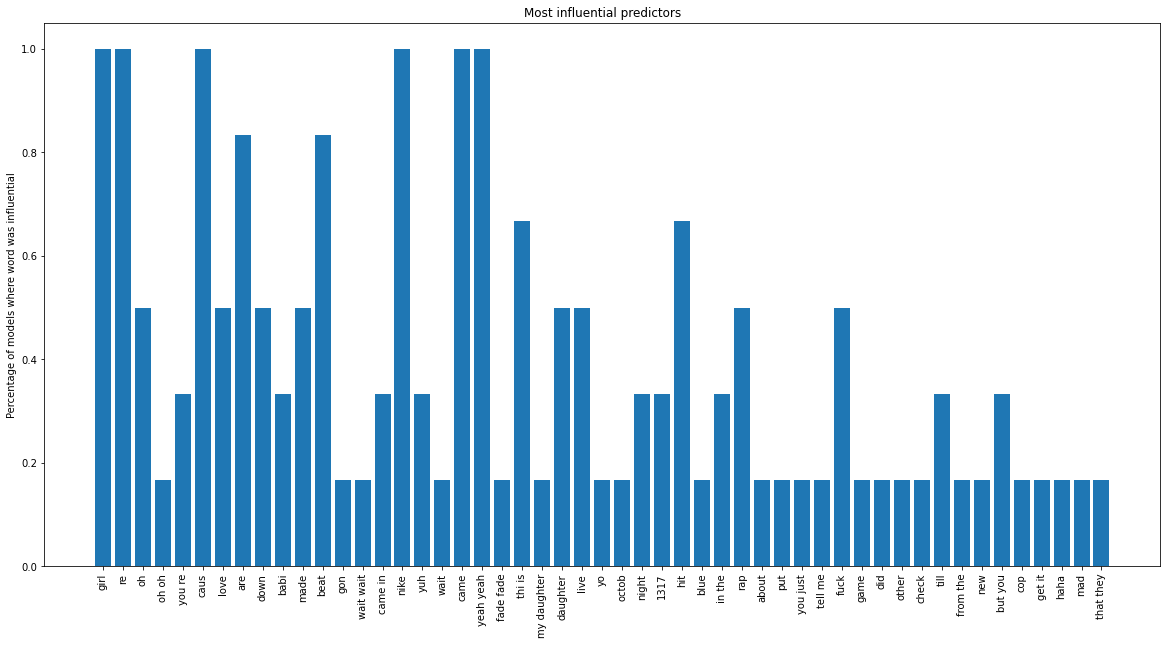

In [45]:
plt.figure(figsize=(20,10))
t=Counter(l_tot)
plt.bar(t.keys(), [x/6 for x in t.values()])
plt.xticks(rotation='vertical')
plt.ylabel("Percentage of models where word was influential")
plt.title("Most influential predictors")
plt.show;

In [46]:
print("Top drake predictors")
[print(x) for x in Counter(l_drake)]
print("\nTop Quentin Miller predictors")
[print(x) for x in Counter(l_quen)];
# print("Generally influential predictors")
# [print(x) for x in total_tokens]

Top drake predictors
girl
re
oh
oh oh
you re
caus
love
are
down
babi
fade fade
thi is
yo
octob
night

Top Quentin Miller predictors
made
beat
gon
wait wait
came in
nike
yuh
wait
came
yeah yeah
my daughter
daughter
live
1317
hit
blue


### Comparison of Drake Albums

In [47]:
# clean up memory to make sure there's space for reorganized corpus
del X_train
del y_train 

#reorganize corpus by album for further exploration of which songs are most "Drake-like"
album_dict={}
song_titles_dict={}
for album in drake: 
    if len(album) < 10:
        continue
    album_dict[album[0]['album'].strip()]= [stop_removal(song['lyrics']) for song in album]
    song_titles_dict[album[0]['album'].strip()] = [song['title'] for song in album]

In [48]:
len(album_dict[album_key])

NameError: name 'album_key' is not defined

In [ ]:
album_mean={}
for album_key in album_dict:
    X_train= model_dict[best_key]['tfidf'].transform(model_dict[best_key]['vect'].transform(album_dict[album_key]))
    preds=model_dict[best_key]['clf'].predict_proba(X_train)[:,0]
    album_mean[album_key]=np.mean(preds)

In [ ]:
plt.bar(album_mean.keys(), album_mean.values())
plt.xticks(range(len(album_mean)), album_mean.keys(), rotation='vertical')
plt.ylim(0.5,1)
plt.ylabel("Mean probability album's songs are by 'Drake'")
plt.title("'Drakeness' of Drake albums based on 7 models")
plt.show()

## Future Work on the Drake-Miller Controversy

- <ins>Cleaning the data</ins>: some of the songs that were misclassified were 'outlier' songs in terms of being abnormally short or non-traditional (for example, a spoken word intro). These songs could be removed in future iterations to improve classification accuracy. Other preprocessing choices are available such as lemmatization over stemming or more aggressive removal of stop words.   
- <ins>Supplementing the data </ins>: The relative easiness of the binary classification problem limits how optimistic we can be about the results on the piece of ambiguous authorship. Even though our models suggest that portions of iyrtitl were more likely to be written by Quentin Miller than other Drake songs, it could well be that the album was simply differnt than other Drake projects and not actually closer to Miller's style. It could be that the album was closer to some other artist Drake was trying to imitate at the time. Future attempts might add 'noise' to the task by including other artists and turning it into a multi-class problem to see if iyrtitl's relative closeness to Miller's style still bears out. The data folder of this project already has albums from J. Cole -[an artist found to be close to Drake](https://pudding.cool/2017/09/hip-hop-words/)- and PartyNextDoor - a frequent collaborator who has also received writing credits on Drake songs. 
- <ins>Changing document size</ins>: So far, we've analyzed songs as documents. A different approach might scale upwards by looking at whole albums as a single document or scale downards by looking at individual verses, bars, or lines as documents. The latter few approaches could be interesting by trying to go beyond the bag of words or even basic word-embedding approach by attempting to learn rhyme scheme, assonance, consonance, and meter.
- <ins>Additional models</ins> Beyond improving the existing models with better hyperparameters, other classification strategies could provide further insight into the data. Based on the success of linear modeling, perhaps LDA (or even QDA) would also be a solid classifier. Other unsupervised methods (PCA, Clustering), could offer insight into similarities and better visualizations of the distance between individual songs and albums.
- <ins>Full stacking algorithm</ins>: The final model presented is a naive ensemble method that merely aggregates predictions of the 7 other models. There could be some advantages to this approach compared to simply picking a single model based on validation accuracy because of the disparate preprocessing procedures. At present, there was a small positive effect on test set performance which indicates there is some potential to the idea. One easy step to improve the current aggregate approach would be weighting sub-models based on their performance metrics. The most empircally robust approach, though, would be to implement a full stacking algorithm where we deploy models based on their effectiveness on subsets of the feature space. Stacking is generally conducted with weaker, more independent learners than those used in the present appraoch. Thus, stacking would require a substantial rework of the base learners. However, considering the size and sparsity of the feature space, it is very possible some models do better than others in certain cases, meaning there could be additional performance gains to be had through stacking. 
- <ins>Statistical approach</ins>: This method took a more machine learning-centric approach in optimizing on classification accuracy. We made relatively few assumpsions about the data by trying all sorts of differnt models. At present, each model had unique preprocessing. This choice limits the efficacy of our interpretive efforts and our ability to compare models beyond classification performance. For instance, the lack of standard scaling means that we really can't compare the magnitude of coefficients across models to determine which words are most influential beyond the fuzzy "15 most influential features" approach employed here. Now that we've found linear models to perform well, we could hone in on these methods and make further assumpsions to gain insight into how each author uses contextual and non-contextual words differently. 
- <ins>Further nueral network exploration</ins>: The current convolutional nueral network is a very simple model, in part due to limitations in processing power. Beyond experimentation with different architectures or hyperparameters, we could also try using pretrained word embeddings (eg GloVe, Fasttext, Word2Vec) to get better predictions while also keeping training time manageable. 

## Future Applications
- <ins>Ghostwriting in hip-hop</ins>: So far we've looked at the most famous example of ghostwriting in hip hop. This approach could be applied to rumored ghostwriting connections (see basically any Dr. Dre or P. Diddy song). It could also be applied to credited writers to see how much a song is a collaborative affair vs. a case of the credited writer doing most of the lifting with the artist just taking credit for it. The most ambitious application, however, would be a 'cold start' approach where we have to look for ghostwriting or plagiarism without knowing in advance who is the most likely ghost writer. For instance, what if Miller had never been outed? Could an algorithm have identified Miller out of a broad set of artists as the real author of "10 Bands?" As mentioned above, the multiclass problem increases the complexity immensely, so at present it seems unlikely 'cold start' identifications are possible. Probably somewhere in the middle - where a set of potential writers are identified in advance and then machine learning tries to find stylistic similarity/influence  - is the most promising area for future work. 